In [1]:
import pandas as pd 
import numpy as np
from xgboost import XGBClassifier
import shap
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

C:\Users\jun99\AppData\Local\Temp\ipykernel_4032\2229420901.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
train = pd.read_csv('../data/train_concat.csv')

ex1 = pd.read_csv('../data_0220_2024/data_0220.csv', encoding='cp949')

In [4]:
ex1.columns = ['연구등록번호', '(실명)등록번호', 'age', 'sex', 'HTN', 'DM', 'tpro', 'alb', 'chol',
       'bun', 'cr', 'eGFR', 'glu', 'plt', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_', 'pcr_urine', 'Dysmorphic RBC',
       'G1 dysmorphic', 'glu_urine', 'esterase_urine', 'RBC', 'WBC', 'Biopsy',
       'Reason']
ex1.columns

Index(['연구등록번호', '(실명)등록번호', 'age', 'sex', 'HTN', 'DM', 'tpro', 'alb', 'chol',
       'bun', 'cr', 'eGFR', 'glu', 'plt', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_', 'pcr_urine', 'Dysmorphic RBC', 'G1 dysmorphic',
       'glu_urine', 'esterase_urine', 'RBC', 'WBC', 'Biopsy', 'Reason'],
      dtype='object')

In [5]:
ex_copy = ex1[['age', 'sex', 'HTN', 'DM', 'plt', 'alb',
       'bun', 'cr', 'eGFR', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_urine', 'glu', 'RBC', 'WBC','Biopsy']].copy()
print(ex_copy.columns)
ex_copy.head()

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC', 'Biopsy'],
      dtype='object')


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy
0,52,1,1,0,230,4.5,18.2,1.02,84.112709,2.0,1.0,328.3,0.8571,104,20,2,1
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2,0
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2,0
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2,0
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2,0


In [55]:
print(train.shape)

print(ex_copy.shape)
ex_copy.Biopsy.value_counts()

(18513, 24)
(632, 21)


Biopsy
0    565
1     67
Name: count, dtype: int64

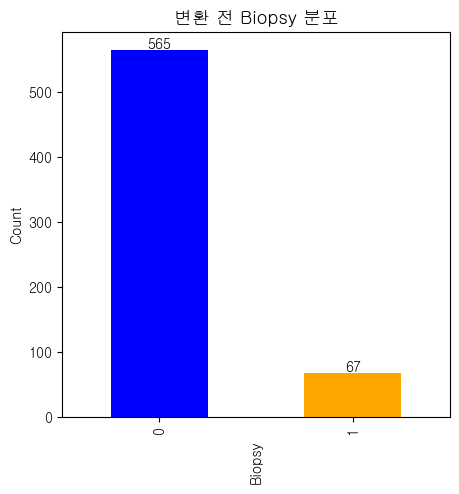

In [65]:
import matplotlib.pyplot as plt

# Bar plot of ex_copy.Biopsy
plt.figure(figsize=(5, 5))
ax = ex_copy['Biopsy'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Biopsy', rotation='vertical')
plt.ylabel('Count')

# Add count labels
for i, count in enumerate(ex_copy['Biopsy'].value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('변환 전 Biopsy 분포', fontsize=13)
plt.show()


In [7]:
train.drop(['group'], axis=1, inplace=True)

print(train.shape)

print(ex_copy.shape)

(18513, 24)
(632, 17)


In [8]:
train_columns = set(train.columns)
ex1_columns = set(ex_copy.columns)

variable_difference = train_columns - ex1_columns
print(f"train 변수에서 validation 변수 제외한 변수들:{list(variable_difference)}")

train 변수에서 validation 변수 제외한 변수들:['RBC_re', 'target', 'esterase_binary', 'esterase_urine', 'RBC_binary', 'tpro', 'glu_urine', 'WBC_re', 'WBC_binary', 'dysmorphism']


In [9]:
# # ex_copy
# ex_copy['RBC_re'] = ex_copy['RBC'].apply(lambda x: 1 if 1 > x else 2 if 5> x >= 1 else 3 if 10 > x >= 5 else
#                                      4 if 20 > x >= 10 else 5 if 30 > x >= 20 else 6 if 40 > x >= 30 else 
#                                      7 if x >= 40 else x)

# ex_copy['WBC_re'] = ex_copy['WBC'].apply(lambda x: 1 if 1 > x else 2 if 5> x >= 1 else 3 if 10 > x >= 5 else
#                                      4 if 20 > x >= 10 else 5 if 30 > x >= 20 else 6 if 40 > x >= 30 else 
#                                      7 if x >= 40 else x)

In [10]:
print(train.shape)

train.columns = ['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC', 'WBC',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'target']

(18513, 24)


In [11]:
print(ex_copy['WBC'].value_counts())
ex_copy['RBC'].value_counts()

WBC
2     471
5      80
20     28
10     24
30     24
0       4
3       1
Name: count, dtype: int64


RBC
2     411
5      77
30     71
20     38
10     35
Name: count, dtype: int64

In [12]:
test = ex_copy.drop(['Biopsy'], axis=1)
test.head()

,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC
0,52,1,1,0,230,4.5,18.2,1.02,84.112709,2.0,1.0,328.3,0.8571,104,20,2
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2


### EDA

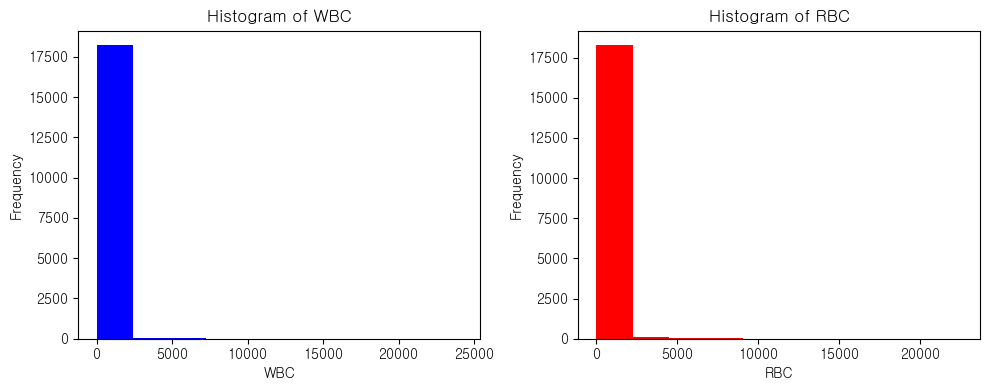

                WBC           RBC
count  18285.000000  18435.000000
mean      57.883298    112.337445
std      535.314708    746.010493
min        0.000000      0.000000
25%        2.900000      4.600000
50%        6.400000     12.300000
75%       16.700000     36.200000
max    24193.000000  22565.200000


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot histogram for WBC
axes[0].hist(train['WBC'], bins=10, color='blue')
axes[0].set_xlabel('WBC')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of WBC')

# Plot histogram for RBC
axes[1].hist(train['RBC'], bins=10, color='red')
axes[1].set_xlabel('RBC')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of RBC')

plt.tight_layout()
plt.show()

print(train[['WBC','RBC']].describe())

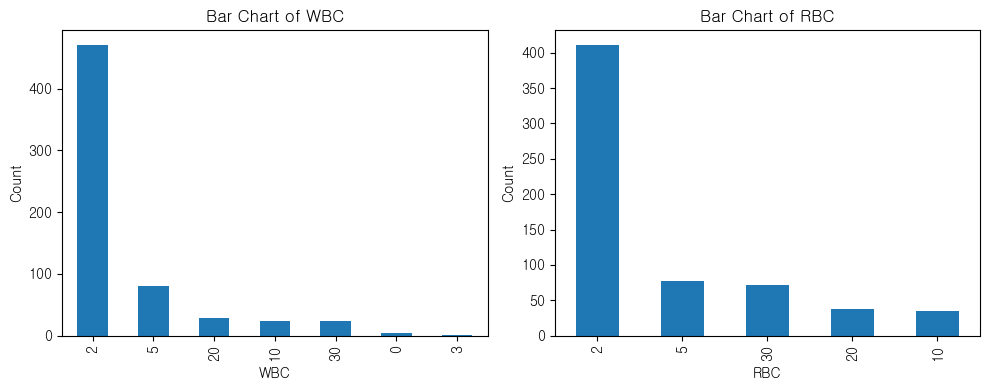

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot bar chart for WBC
ex_copy['WBC'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('WBC')
axes[0].set_ylabel('Count')
axes[0].set_title('Bar Chart of WBC')

# Plot bar chart for RBC
ex_copy['RBC'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('RBC')
axes[1].set_ylabel('Count')
axes[1].set_title('Bar Chart of RBC')

plt.tight_layout()
plt.show()


In [15]:
ex_copy['WBC_cat'] = ex_copy['WBC'].astype('category')
ex_copy['RBC_cat'] = ex_copy['RBC'].astype('category')

print(ex_copy['WBC_cat'].value_counts().sort_index())
print(ex_copy['RBC_cat'].value_counts().sort_index())

print(ex_copy['WBC_cat'].describe())
print(ex_copy['RBC_cat'].describe())


WBC_cat
0       4
2     471
3       1
5      80
10     24
20     28
30     24
Name: count, dtype: int64
RBC_cat
2     411
5      77
10     35
20     38
30     71
Name: count, dtype: int64
count     632
unique      7
top         2
freq      471
Name: WBC_cat, dtype: int64
count     632
unique      5
top         2
freq      411
Name: RBC_cat, dtype: int64


## Modeling

In [16]:
xgb = XGBClassifier(random_state = 2023, n_jobs=-1)

In [17]:
print(test.columns)
print(train.columns)

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC'],
      dtype='object')
Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC', 'WBC',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'target'],
      dtype='object')


In [18]:
column_difference = set(ex_copy.columns).difference(set(train.columns))
print(f'val - train:{column_difference}')

column_difference = set(train.columns).difference(set(ex_copy.columns))
print(f'train - val:{column_difference}')

val - train:{'RBC_cat', 'Biopsy', 'WBC_cat'}
train - val:{'target', 'esterase_binary', 'esterase_urine', 'RBC_binary', 'tpro', 'glu_urine', 'WBC_binary', 'dysmorphism'}


In [19]:
X_train = train.drop(['tpro', 'esterase_urine', 'RBC_binary', 'dysmorphism',
                      'esterase_binary', 'glu_urine', 'WBC_binary', 'target'], axis=1).copy()
y_train = train['target'].copy()

In [20]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=2023, ...)

### test

In [21]:
test_pred = xgb.predict(test)
test_pred_prob = xgb.predict_proba(test)

In [22]:
ex_copy['pred'] = test_pred
ex_copy['pred_prob'] = test_pred_prob[:,1]

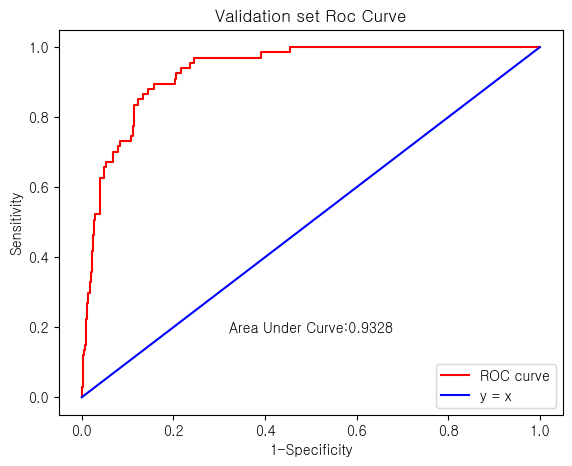

In [23]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy['Biopsy']), test_pred_prob[:,1])

plt.figure(figsize=(6.5, 5))
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy['Biopsy']), test_pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)

plt.title('Validation set Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.legend() # 그래프 라벨 표시

plt.show()

In [24]:
accuracy = accuracy_score(ex_copy['Biopsy'], test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.61%


In [25]:
print(classification_report(ex_copy['Biopsy'], test_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       565
           1       0.62      0.54      0.58        67

    accuracy                           0.92       632
   macro avg       0.78      0.75      0.76       632
weighted avg       0.91      0.92      0.91       632



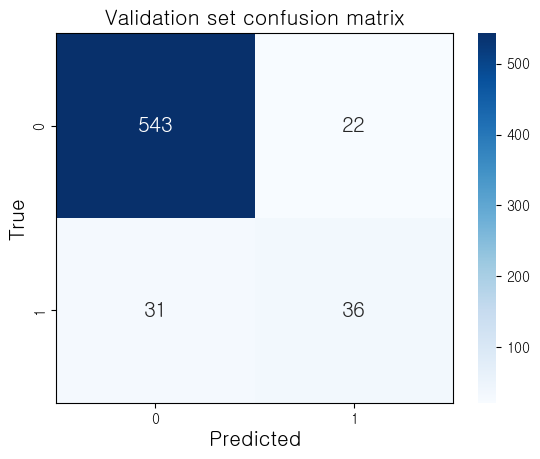

In [26]:
cm = confusion_matrix(ex_copy['Biopsy'], test_pred)

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('Validation set confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

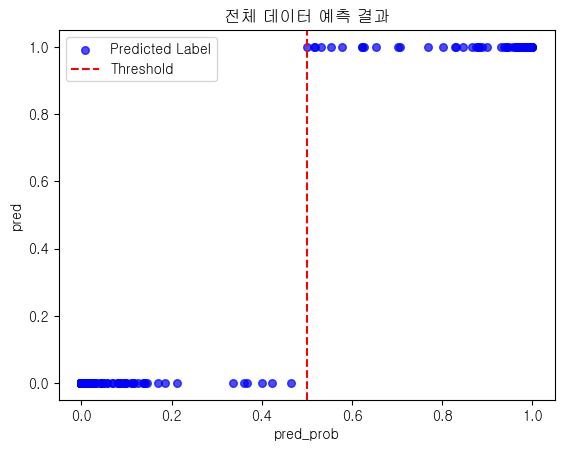

In [27]:
plt.scatter(ex_copy['pred_prob'], ex_copy['pred'], color='blue', label='Predicted Label', alpha=0.7, s=30)

# Add the sigmoid-shaped line at 0.5 threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')

plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('전체 데이터 예측 결과')
plt.legend()
plt.show()

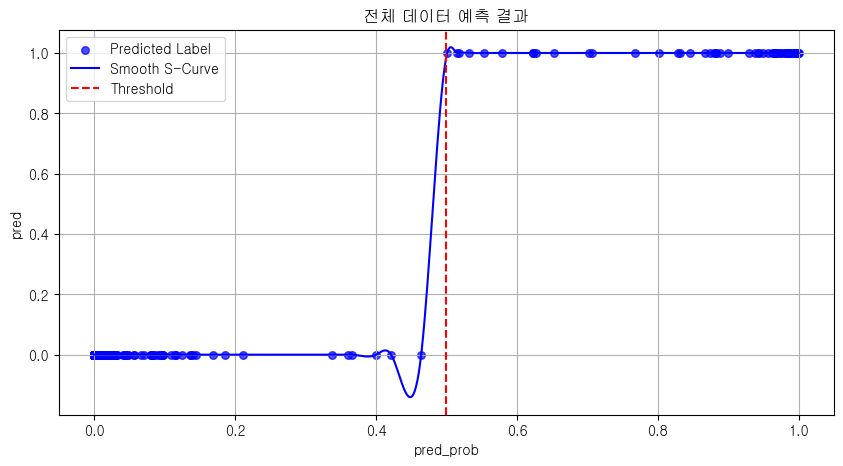

In [28]:
from scipy.interpolate import interp1d

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(test_pred_prob[:,1])
sorted_ex_copy_pred_prob = test_pred_prob[:,1][sorted_indices]
sorted_ex_copy_pred = test_pred[sorted_indices]

# 보간 함수 생성
f = interp1d(sorted_ex_copy_pred_prob, sorted_ex_copy_pred, kind='cubic')

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)


# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(test_pred_prob[:,1], test_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Smooth S-Curve')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('전체 데이터 예측 결과')
plt.legend()
plt.grid(True)
plt.show()


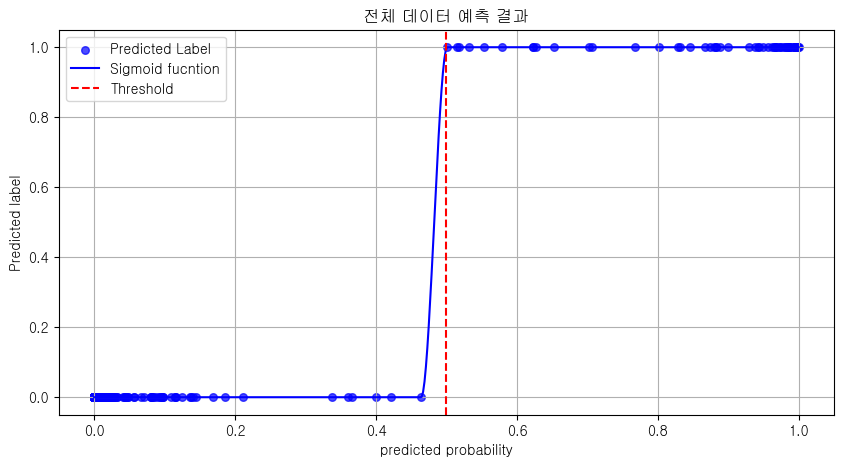

In [29]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(test_pred_prob[:,1])
sorted_ex_copy_pred_prob = test_pred_prob[:,1][sorted_indices]
sorted_ex_copy_pred = test_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(test_pred_prob[:,1], test_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('전체 데이터 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

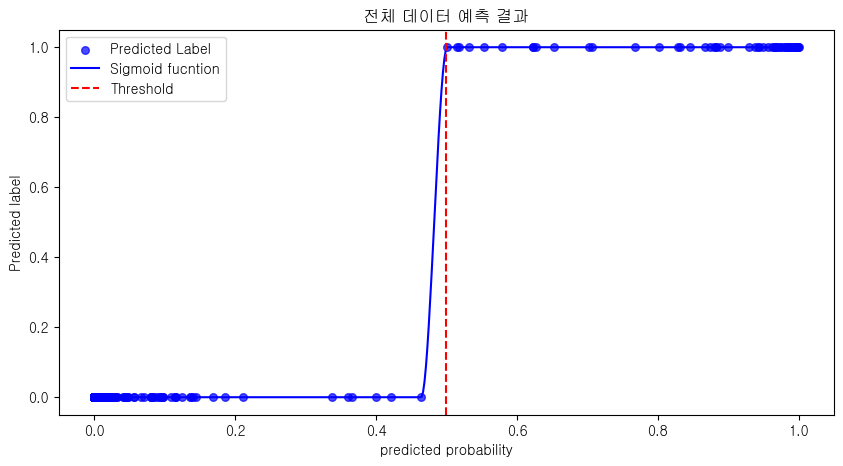

In [30]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(test_pred_prob[:,1])
sorted_ex_copy_pred_prob = test_pred_prob[:,1][sorted_indices]
sorted_ex_copy_pred = test_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(test_pred_prob[:,1], test_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('전체 데이터 예측 결과')
plt.legend()
plt.grid(False)
plt.show()

### 10% 중간 영역 제외

In [31]:
ex_copy.pred_prob.head()

0    0.464096
1    0.996576
2    0.000010
3    0.000205
4    0.000026
Name: pred_prob, dtype: float32

In [32]:
# 8개 제외됨
ex_copy_no_middle_10 = ex_copy[(ex_copy['pred_prob'] < 0.45) | (ex_copy['pred_prob'] > 0.55)].copy()
print(ex_copy_no_middle_10.shape)
ex_copy_no_middle_10.head()

(627, 21)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,...,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,WBC_cat,RBC_cat,pred,pred_prob
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,...,1224.4,1.8593,88,20,2,0,2,20,1,0.996576
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,...,185.6,0.2984,276,2,2,0,2,2,0,0.000010
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,...,8.0,0.0382,104,2,2,0,2,2,0,0.000205
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,...,8.0,0.1232,90,2,2,0,2,2,0,0.000026
5,60,1,0,0,255,5.1,13.2,0.95,86.653354,0.0,...,868.3,1.3104,114,2,5,0,5,2,1,0.976329


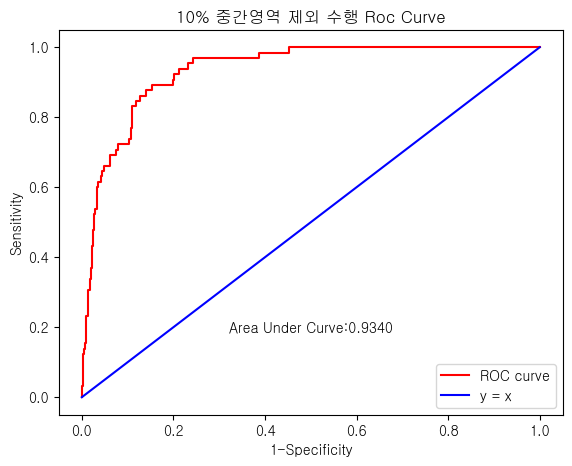

In [33]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle_10['Biopsy']), ex_copy_no_middle_10['pred_prob'])

plt.figure(figsize=(6.5,5))

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle_10['Biopsy']), ex_copy_no_middle_10['pred_prob'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('10% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [34]:
accuracy = accuracy_score(ex_copy_no_middle_10['Biopsy'], ex_copy_no_middle_10['pred'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.19%


In [35]:
print(classification_report(ex_copy_no_middle_10['Biopsy'], ex_copy_no_middle_10['pred']))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       562
           1       0.65      0.54      0.59        65

    accuracy                           0.92       627
   macro avg       0.80      0.75      0.77       627
weighted avg       0.92      0.92      0.92       627



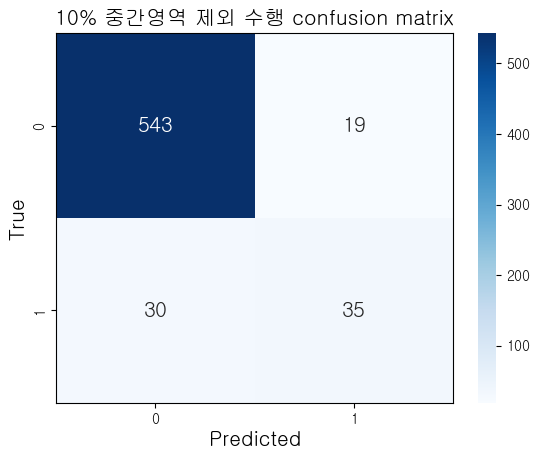

In [36]:
cm = confusion_matrix(ex_copy_no_middle_10['Biopsy'], ex_copy_no_middle_10['pred'])

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('10% 중간영역 제외 수행 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

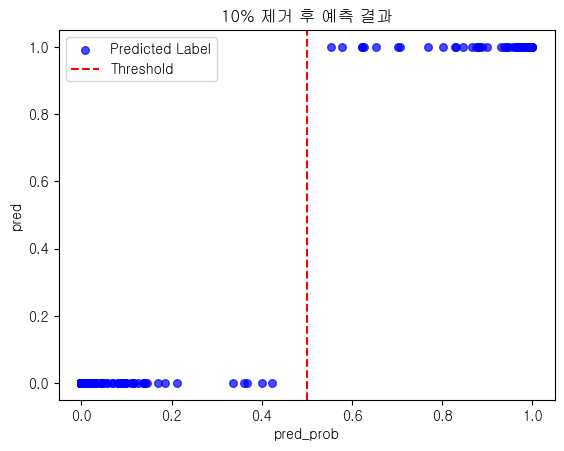

In [37]:
plt.scatter(ex_copy_no_middle_10['pred_prob'], ex_copy_no_middle_10['pred'], color='blue', label='Predicted Label', alpha=0.7, s=30)

# Add the sigmoid-shaped line at 0.5 threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')

plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.show()

In [38]:
middle_10_pred_prob = np.array(ex_copy_no_middle_10['pred_prob'])
middle_10_pred = np.array(ex_copy_no_middle_10['pred'])

print(len(middle_10_pred_prob))
print(len(ex_copy_no_middle_10['pred_prob']))

627
627


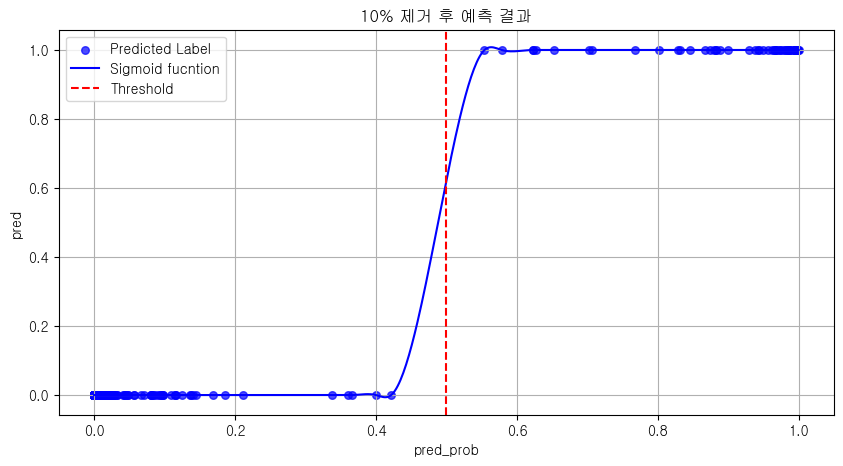

In [39]:
from scipy.interpolate import interp1d

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# 보간 함수 생성
f = interp1d(sorted_ex_copy_pred_prob, sorted_ex_copy_pred, kind='cubic')

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()


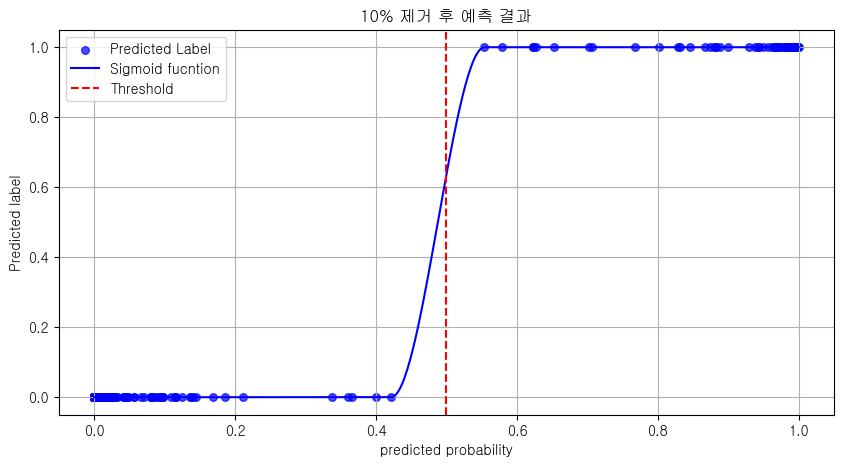

In [40]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

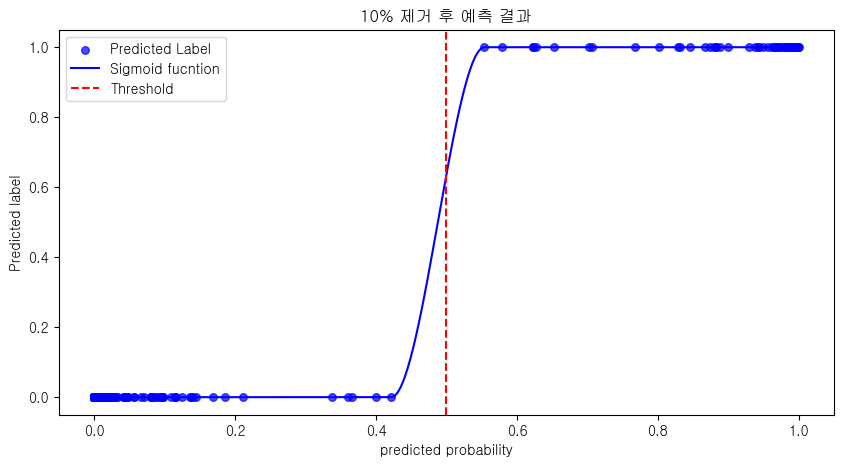

In [41]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('10% 제거 후 예측 결과')
plt.legend()
plt.grid(False)
plt.show()

### 20% 중간 영역 제외

In [42]:
test.columns

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC'],
      dtype='object')

In [43]:
ex_copy.pred_prob.head()

0    0.464096
1    0.996576
2    0.000010
3    0.000205
4    0.000026
Name: pred_prob, dtype: float32

In [44]:
# 8개 제외됨
ex_copy_no_middle = ex_copy[(ex_copy['pred_prob'] < 0.4) | (ex_copy['pred_prob'] > 0.6)].copy()
print(ex_copy_no_middle.shape)
ex_copy_no_middle.head()

(624, 21)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,...,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,WBC_cat,RBC_cat,pred,pred_prob
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,...,1224.4,1.8593,88,20,2,0,2,20,1,0.996576
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,...,185.6,0.2984,276,2,2,0,2,2,0,0.000010
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,...,8.0,0.0382,104,2,2,0,2,2,0,0.000205
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,...,8.0,0.1232,90,2,2,0,2,2,0,0.000026
5,60,1,0,0,255,5.1,13.2,0.95,86.653354,0.0,...,868.3,1.3104,114,2,5,0,5,2,1,0.976329


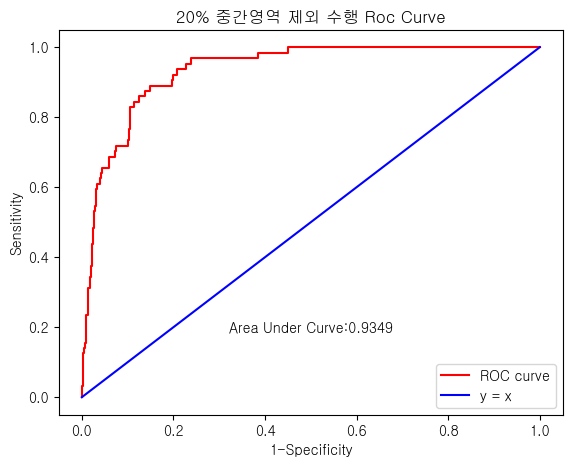

In [45]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle['Biopsy']), ex_copy_no_middle['pred_prob'])

plt.figure(figsize=(6.5,5))

# auc 계산
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle['Biopsy']), ex_copy_no_middle['pred_prob'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('20% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [46]:
accuracy = accuracy_score(ex_copy_no_middle['Biopsy'], ex_copy_no_middle['pred'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.63%


In [47]:
print(classification_report(ex_copy_no_middle['Biopsy'], ex_copy_no_middle['pred']))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       560
           1       0.67      0.55      0.60        64

    accuracy                           0.93       624
   macro avg       0.81      0.76      0.78       624
weighted avg       0.92      0.93      0.92       624



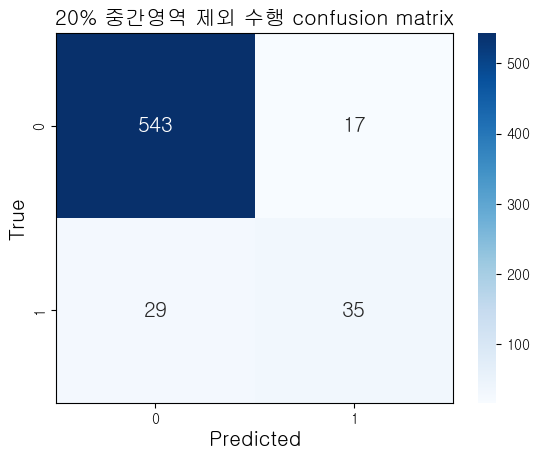

In [48]:
cm = confusion_matrix(ex_copy_no_middle['Biopsy'], ex_copy_no_middle['pred'])

# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('20% 중간영역 제외 수행 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

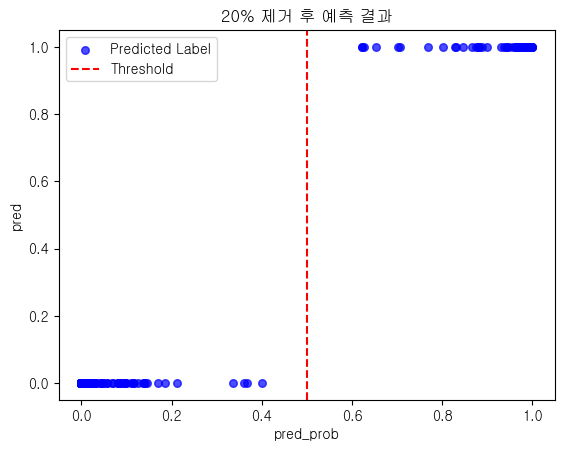

In [49]:
plt.scatter(ex_copy_no_middle['pred_prob'], ex_copy_no_middle['pred'], color='blue', label='Predicted Label', alpha=0.7, s=30)

# Add the sigmoid-shaped line at 0.5 threshold
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')

plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.show()

In [50]:
middle_pred_prob = np.array(ex_copy_no_middle['pred_prob'])
middle_pred = np.array(ex_copy_no_middle['pred'])

print(len(middle_pred_prob))
print(len(ex_copy_no_middle['pred_prob']))

624
624


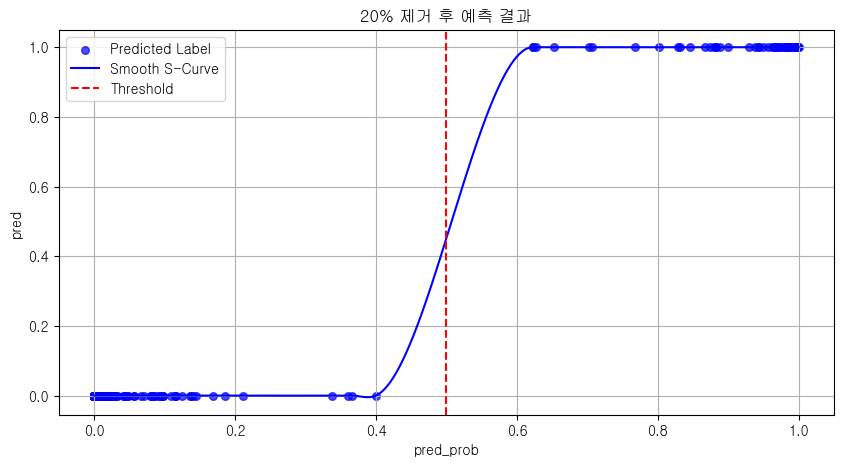

In [51]:
from scipy.interpolate import interp1d

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# 보간 함수 생성
f = interp1d(sorted_ex_copy_pred_prob, sorted_ex_copy_pred, kind='cubic')

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Smooth S-Curve')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('pred_prob')
plt.ylabel('pred')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()


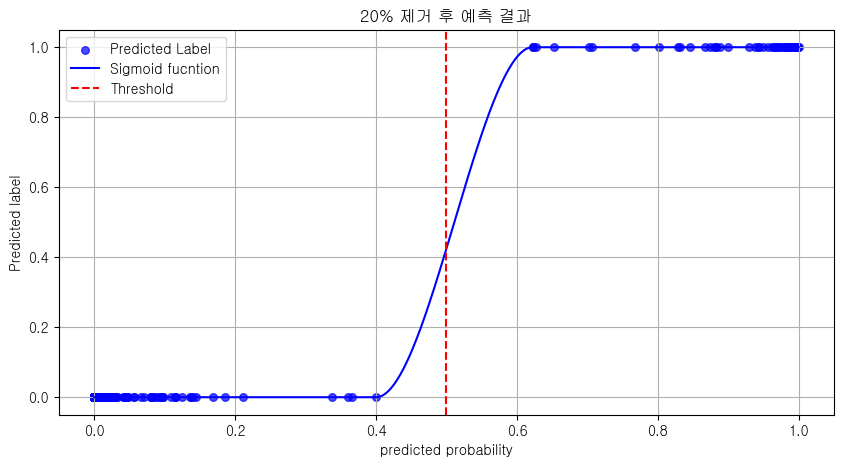

In [52]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

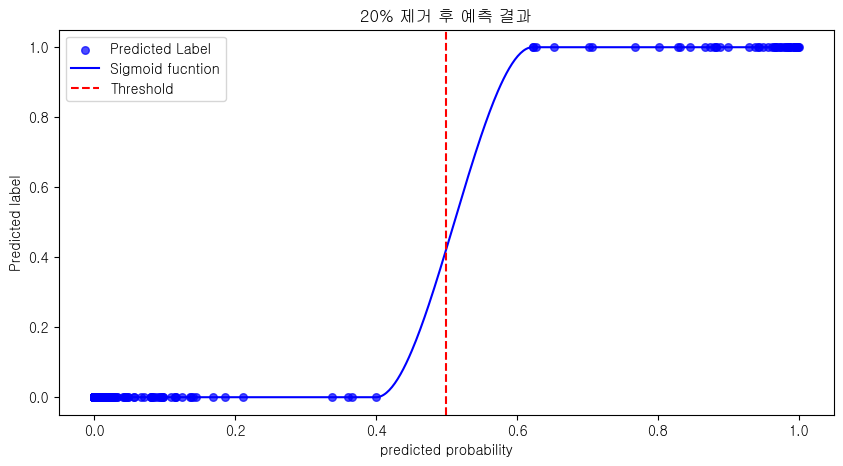

In [53]:
from scipy.interpolate import PchipInterpolator

# 격자 없이 
# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('20% 제거 후 예측 결과')
plt.legend()
plt.grid(False)
plt.show()